In [6]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('icefire')

import warnings
warnings.filterwarnings('ignore')

import pickle

In [7]:
index = 'ATX'
root = f'../models/{index}/baseline'

### Summaries (Project metrics)

In [10]:
results = []
for path in glob.glob(f'{root}/*/*/*'):
    try:
        with open(os.path.join(path, 'project_metrics-1.pkl'), 'rb') as f:
            data = pickle.load(f)
            
        [index, _, window, model_config, commodity] = path.split('/')[2:]
        base_model = 'Peephole_LSTM' if model_config.startswith('Peephole_LSTM') else ('GRU' if 'GRU' in model_config else 'LSTM')
        model_config = model_config.replace(f'{base_model}_', '').replace(f'{base_model}', '')
        r = dict(index = index, window = window, base_model = base_model, model_config = model_config, commodity = commodity)
        r.update(data)
        results.append(r)
    except:
        print(path)

In [11]:
df = pd.DataFrame(results)
df['window'] = df['window'].apply(int)
df.head()

,index,window,base_model,model_config,commodity,mae,mse,rmse,mad,hmse,hmae,mape,r2_hetro,aic,bic,r2
0,ATX,7,Peephole_LSTM,garch_gjr_garch,without_commodity_prices,0.004485,0.000041,0.006381,0.004701,8.631449,6.047860,0.447810,0.012490,-3751.310724,-3742.873524,-0.218019
1,ATX,7,Peephole_LSTM,garch_gjr_garch,with_commodity_prices,0.004649,0.000044,0.006669,0.004872,11.293804,7.866127,0.456046,0.010364,-3734.056923,-3725.627706,-0.327028
2,ATX,7,GRU,garch,without_commodity_prices,0.002674,0.000015,0.003844,0.004460,6.302103,4.340276,0.261918,0.690805,-4334.239664,-4325.802464,0.558123
3,ATX,7,GRU,garch,with_commodity_prices,0.002859,0.000018,0.004200,0.004438,6.139991,4.163593,0.252731,0.683677,-4304.343855,-4295.914638,0.473524
4,ATX,7,Peephole_LSTM,garch_egarch,without_commodity_prices,0.004260,0.000032,0.005691,0.004683,4.949591,3.622659,0.460715,0.075367,-3784.337239,-3775.900039,0.031258


In [12]:
# Save summaries
df.to_csv(f'../models/{index}/summary.csv')

##### Effect of training with commodity prices

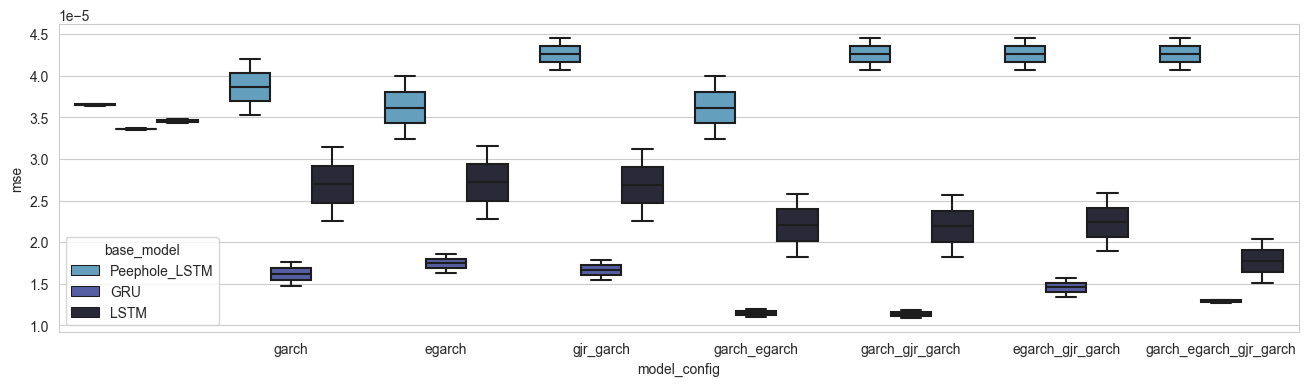

In [13]:
plt.figure(figsize = (16, 4))
order = ['', 'garch', 'egarch','gjr_garch', 'garch_egarch', 'garch_gjr_garch', 'egarch_gjr_garch', 'garch_egarch_gjr_garch']
sns.boxplot(data = df[(df['window'] == 7)], x = 'model_config', y = 'mse', hue = 'base_model', order = order)
plt.show()

##### Performance comparision

In [14]:
## Read predictions
dfs = []
for path in glob.glob(f'{root}/*/*/*'):
    with open(f'{path}/valid_predictions-1.pkl', 'rb') as f:
        preds = pickle.load(f)
        preds[-1] = preds[-1].flatten()
        df_preds = pd.DataFrame(preds).T
        df_preds.columns = ['date', 'gt', 'prediction']
        [index, _, window, model_config, commodity] = path.split('/')[2:]
        base_model = 'Peephole_LSTM' if model_config.startswith('Peephole_LSTM') else ('GRU' if 'GRU' in model_config else 'LSTM')
        model_config = model_config.replace(f'{base_model}_', '').replace(f'{base_model}', '')
        df_preds[['index', 'window', 'base_model' ,'model_config', 'commodity']] = [index, window, base_model, model_config, commodity]
        df_preds['date'] = pd.to_datetime(df_preds['date'])
        dfs.append(df_preds)
        
df_preds = pd.concat(dfs)
df_preds['window'] = df_preds['window'].apply(int)
df_preds.shape

(94176, 8)

In [15]:
model_config = ['', 'garch', 'egarch', 'gjr_garch', 'garch_egarch', 'garch_gjr_garch', 'egarch_gjr_garch', 'garch_egarch_gjr_garch']

In [16]:
def make_plot(base_model, window, show_plot = True):
    print(f'Base model: {base_model}, window: {window}')
    fig, axes = plt.subplots(4, 2, figsize = (12, 12), sharex = False)
    for idx, ax in enumerate(axes.flatten()):
        if idx < len(model_config):
            sub = df_preds[(df_preds['base_model'] == base_model) & \
                (df_preds['model_config'] == model_config[idx]) & \
                (df_preds['window'] == window)]
            sns.lineplot(data = sub[sub['commodity'] == 'with_commodity_prices'], ci = None,
                         x = 'date', y = 'gt', color = 'blue', label = 'Ground truth',  ax = ax)
            sns.lineplot(data = sub[sub['commodity'] == 'with_commodity_prices'], ci = None,
                        x = 'date', y = 'prediction', label = 'with_commodity', color = 'red', ax = ax)
            sns.lineplot(data = sub[sub['commodity'] == 'without_commodity_prices'], ci = None,
                        x = 'date', y = 'prediction', label = 'without_commodity', color = 'orange', ax = ax)
            ax.set_title(model_config[idx])
            ax.set_ylabel('Realized volatility')
            ax.legend()
            ax.set_xlabel(None)
        else:
            ax.remove()

    plt.tight_layout()
    os.makedirs(f'../models/{index}/plots', exist_ok= True)
    plt.savefig(f'../models/{index}/plots/{base_model}_{window}.png', bbox_inches='tight')
    if show_plot:
        plt.show()
    else:
        plt.close()

In [17]:
for base_model in ['LSTM', 'GRU', 'Peephole_LSTM']:
    for window in [7, 14, 21, 28]:
        make_plot(base_model, window, show_plot = False)

Base model: LSTM, window: 7
Base model: LSTM, window: 14
Base model: LSTM, window: 21
Base model: LSTM, window: 28
Base model: GRU, window: 7
Base model: GRU, window: 14
Base model: GRU, window: 21
Base model: GRU, window: 28
Base model: Peephole_LSTM, window: 7
Base model: Peephole_LSTM, window: 14
Base model: Peephole_LSTM, window: 21
Base model: Peephole_LSTM, window: 28
